# Importance sampling in domain transfer: toy example batch sampling
This is an toy example that demonstrates our importance sampling method used in unsupervised domain transfer. The problem we are addressing is that of the domains having non-matching distributions, which is often the case in GAN data sets. We use importance sampling to correct for this mis-match in domain distributions.

For this example we use a color dataset, consisting of images of spatial size $1\times1$. The idea is to have the domains consist of two modes: a dark and a light image. The goal is to correct for the dissimilar modes in the distribution using the weighting network in combination with importance sampling. The big assumption here is that dark and light images in the domains have semantic correspondence and that these modes are supposed to be equal.

In unsupervised domain transfer, there exist no image pairs or ground truth for these kind of distributions: they are unknown. This is also the case in our example. To enforce semantic correspondence we add a simple static conditional generator that maps images to another color domain with the same brightness.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    return image_batch

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.softmax(self.fc2(h1))
        return out

In [6]:
class TrivialWeightNet(nn.Module):
    '''A trivial network that predicts the importances of the samples'''

    def __init__(self):
        super(TrivialWeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        out = torch.ones((x.size()[0], 1))
        out /= out.sum()
        return out

In [7]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(6, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 6)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [8]:
class TrivialDiscriminator(nn.Module):
    '''A trivial joint discriminator network'''

    def __init__(self):
        super(TrivialDiscriminator, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        return torch.zeros(x.size()[0], 1)

In [9]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

In [10]:
class TrivialGenerator(nn.Module):
    '''A trivial conditional generator network'''
    
    def __init__(self):
        super(TrivialGenerator, self).__init__()
        self.nn = nn.Linear(1,1) # Otherwise error
        
    def forward(self, x):
        new = torch.zeros((x.shape))
        new[:, 0] = x[:, 1]
        new[:, 1] = x[:, 0]
        return new

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

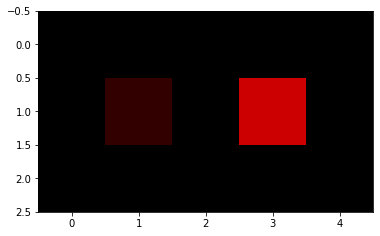

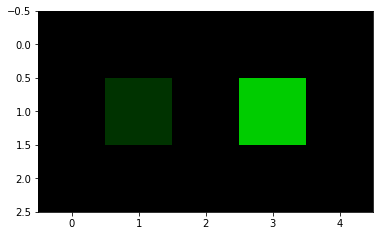

In [11]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.5
color_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.5
color_B = 1
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

True ratio domain A: 0.5
Count: tensor([132, 124]) Ratio in this batch: tensor([0.5156, 0.4844])


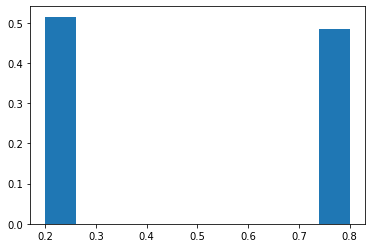

True ratio domain B: 0.5
Count: tensor([133, 123]) Ratio in this batch: tensor([0.5195, 0.4805])


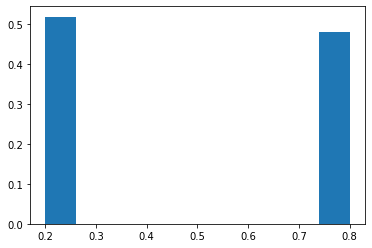

In [12]:
def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
    print('Count:', x_unique_count, 'Ratio in this batch:', x_unique_count/float(x_unique_count.sum()))

    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
    print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    break

## The training loop

In [ ]:
# Initialize the networks
weight_network_A = TrivialWeightNet()
weight_network_B = TrivialWeightNet()
generator_A = Generator()
generator_B = Generator()
discriminator = Discriminator()

# Initialize the optimizers
optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=0.01)
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.01)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.01)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []


sampled_batch_size = 64 # The amount of images sampled using importance sampling
for epoch in range(5):
    for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_w.zero_grad()
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # The sampling process ----------------------------------------------------------------------------
        importances_A = weight_network_A(data_A).squeeze() # Get the importances for each image in domain A
        importances_B = weight_network_B(data_B).squeeze() # Get the importances for each image in domain B

        sampled_idx_A = list( # Sample from batch A according to these importances
            torch.utils.data.sampler.WeightedRandomSampler(importances_A, 
                                                           sampled_batch_size, 
                                                           replacement=False))

        sampled_importances_A = importances_A[sampled_idx_A] # The importances assigned to the smaller batch
        real_A = data_A[sampled_idx_A] # The sampled smaller batch A

        sampled_idx_B = list( # Sample from batch Baccording to these importances
            torch.utils.data.sampler.WeightedRandomSampler(importances_B,
                                                           sampled_batch_size, 
                                                           replacement=False))

        sampled_importances_B = importances_B[sampled_idx_B] # The importances assigned to the smaller batch
        real_B = data_B[sampled_idx_B] # The sampled smaller batch B
        # --------------------------------------------------------------------------------------------------

        # Generated images
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)

        # Discriminator values
        discriminated_A = discriminator(torch.cat((real_A, fake_B)))
        discriminated_B = discriminator(torch.cat((fake_A, real_B)))

        # The loss function --------------------------------------------------------------------------------
        Lmin = (discriminated_A * sampled_importances_A/sampled_importances_A.detach()).sum()
        Lplus = (discriminated_B * sampled_importances_B/sampled_importances_B.detach()).sum()

        loss_g = Lmin - Lplus
        loss_w = (Lmin - Lplus)**2
        loss_d = Lplus - Lmin
        # ---------------------------------------------------------------------------------------------------

        # Backward
        loss_g.backward(retain_graph=True)
        loss_w.backward(retain_graph=True)
        loss_d.backward()

        # Optimization step
        optimizer_g.step()
        optimizer_w.step()
        optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]

        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        losses_w += [loss_w.item()]

        w_a = weight_network_A(dataset_A.example_imgs)
        w_b = weight_network_B(dataset_B.example_imgs)
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g: ', loss_g.item(), 'loss_d: ', loss_d.item(), 'loss_w: ', loss_w.item())

step 0 loss_g:  -8.80419921875 loss_d:  8.80419921875 loss_w:  77.51392364501953
step 500 loss_g:  0.1690673828125 loss_d:  -0.1690673828125 loss_w:  0.02858377993106842
step 1000 loss_g:  -0.034912109375 loss_d:  0.034912109375 loss_w:  0.0012188553810119629
step 1500 loss_g:  0.0185546875 loss_d:  -0.0185546875 loss_w:  0.00034427642822265625
step 2000 loss_g:  -0.03125 loss_d:  0.03125 loss_w:  0.0009765625
step 2500 loss_g:  0.01171875 loss_d:  -0.01171875 loss_w:  0.0001373291015625
step 3000 loss_g:  -0.0015869140625 loss_d:  0.0015869140625 loss_w:  2.518296241760254e-06
step 3500 loss_g:  -0.001220703125 loss_d:  0.001220703125 loss_w:  1.4901161193847656e-06
step 4000 loss_g:  0.001708984375 loss_d:  -0.001708984375 loss_w:  2.9206275939941406e-06
step 4500 loss_g:  -0.0006103515625 loss_d:  0.0006103515625 loss_w:  3.725290298461914e-07
step 5000 loss_g:  -0.0050048828125 loss_d:  0.0050048828125 loss_w:  2.504885196685791e-05
step 5500 loss_g:  0.003662109375 loss_d:  -0.003

In [ ]:
visualize_img_batch(real_A)
visualize_img_batch(fake_B.detach())
print('True ratio domain A {}'.format(ratio_A))
plot_hist(real_A)

visualize_img_batch(real_B)
visualize_img_batch(fake_A.detach())
print('True ratio domain B {}'.format(ratio_B))
plot_hist(real_B)

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.plot(losses_w)
plt.legend(['G', 'D', 'W'])
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.xlabel('Assigned importance')
plt.ylabel('Training iterations')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Ratio between importances of the same mode')
plt.plot(torch.Tensor(example_importances_A)[:, 0]/torch.Tensor(example_importances_B)[:, 0])
plt.plot(torch.Tensor(example_importances_A)[:, 1]/torch.Tensor(example_importances_B)[:, 1])
plt.legend(['Dark images', 'Light images'])
plt.xlabel('Ratio importance')
plt.ylabel('Training iterations')
plt.show()

In [ ]:
for img in samples_B:
    visualize_img_batch(img)